#### Script to diagnose and plot Buoyancy metric from Ahmed et al. 2020.

James Ruppert  
jruppert@ou.edu  
7/15/23

In [1]:
from netCDF4 import Dataset
import numpy as np
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, rc
import cartopy
import os
import pandas as pd
from precip_class import precip_class
from cfads_functions import mask_edges
from thermo_functions import esat, mixr_from_e
from write_ncfile import write_ncfile

In [2]:
# #### Main settings

# NOTE: Using copied tracking from CTL for NCRF tests

storm = 'haiyan'
# storm = 'maria'

# How many members
nmem = 10 # number of ensemble members
# nmem = 2

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/time_series/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

In [3]:
# Prep tests & ens members

def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

# Ens member strings
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

# Get pressure
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
varfil_main = Dataset(datdir+'post/d02/T.nc')
pres = varfil_main.variables['pres'][...]
pres = pres.data
varfil_main.close()
nz=pres.shape[0]
dp = (pres[0]-pres[1])*1e2 # Pa

# WRFOUT file list
path = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
dirlist = os.listdir(path)
subs="wrfout_d02"
wrf_files = list(filter(lambda x: subs in x, dirlist))
wrf_files.sort()
wrf_files = [path + s for s in wrf_files]
wrfout1 = wrf_files[0]

# Get Lat/Lon
ncfile = Dataset(wrfout1)
lon = ncfile.variables['XLONG'][0,0,:]
lat = ncfile.variables['XLAT'][0,:,0]
ncfile.close()
nx1 = lat.shape[0]
nx2 = lon.shape[0]

nt = np.zeros(ntest, dtype=np.int32)
for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()
    nt[itest]=i_nt

In [4]:
# Function to account for crossing of the Intl Date Line
def dateline_lon_shift(lon_in, reverse):
    if reverse == 0:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in < 0)] += 360
    else:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in > 180)] -= 360
    # return lon_in + lon_offset
    return lon_offset

def get_lon_offset_plt():
    # Check for crossing Date Line
    if (lon.min() < 0) and (lon.max() > 0):
        offset = 180
        lon_offset = dateline_lon_shift(lon, reverse=0)
    else:
        offset = 0
        lon_offset = 0
        clon_offset = 0
    lon_offset_plt = lon + lon_offset
    lon_offset_plt -= offset
    return offset, lon_offset_plt

offset, lon_offset_plt = get_lon_offset_plt()

---
#### Variable read and processing functions

In [5]:
def tidy_up(var):
    var = np.squeeze(var)
    var = np.ma.masked_invalid(var, copy=False)
    var = mask_edges(var)
    # Can swap in masking by TC track here
    var = np.ma.filled(var, fill_value=np.nan) # Abandon masking, replace mask with NaNs
    return var

def read_var(datdir, varname):
    readfile = Dataset(datdir+varname.upper()+'.nc')
    var = readfile.variables[varname.upper()][...]
    readfile.close()
    var = tidy_up(var)
    return var

def qvar_read(datdir):
    qfile = Dataset(datdir+'q_int.nc')
    q_int = qfile.variables['q_int'][...]
    qfile.close()
    q_int = tidy_up(q_int)
    return q_int

def read_msevar(datdir):
    readfile = Dataset(datdir+'mse_diag.nc')
    vmfu = readfile.variables['vmfu'][...]
    vmfd = readfile.variables['vmfd'][...]
    mse = readfile.variables['mse_vint'][...]
    readfile.close()
    vmfu = tidy_up(vmfu)
    vmfd = tidy_up(vmfd)
    mse  = tidy_up(mse)
    return vmfu, vmfd, mse

def read_lw_terms(datdir):
    # Vertically integrated radiative terms
    lw_t = read_var(datdir,'LWUPT') - read_var(datdir,'LWDNT') # W/m2
    lw_b = read_var(datdir,'LWUPB') - read_var(datdir,'LWDNB') # W/m2
    lw_net = lw_b - lw_t
    # Clear sky
    lw_tc = read_var(datdir,'LWUPTC') - read_var(datdir,'LWDNTC') # W/m2
    lw_bc = read_var(datdir,'LWUPBC') - read_var(datdir,'LWDNBC') # W/m2 = J/m2/s
    lw_net_cs = lw_bc - lw_tc
    # acre = lw_net - lw_net_cs
    # Direct read from file
    # readfile = Dataset(datdir+'LWacre.nc')
    # acre = readfile.variables['LWUPB'][...]
    # readfile.close()
    # acre = tidy_up(acre)
    lw_net = tidy_up(lw_net)
    lw_net_cs = tidy_up(lw_net_cs)
    return lw_net, lw_net_cs

# def read_buoy(datdir):
#     readfile = Dataset(datdir+filename_out)
#     buoy = readfile.variables['buoy'][...]
#     buoy_avg = readfile.variables['buoy_avg'][...]
#     readfile.close()
#     return buoy, buoy_avg

In [6]:
def calc_mse_budget(mse, lw_net, lw_net_cs):
    # Remove means
    mse_mean = np.nanmean(mse)
    mse_p = mse - mse_mean
    lw_mean = np.nanmean(lw_net)
    lw_p = lw_net - lw_mean
    lw_mean_cs = np.nanmean(lw_net_cs)
    lw_p_cs = lw_net_cs - lw_mean_cs

    # Calculate covariance
    lwmse = mse_p*lw_p # J/m2 * J/m2/s = (J/m2)^2 / s
    msevar = np.nanvar(mse) # (J/m2)^2
    lwmse /= msevar # units = /s
    lwmse *= 3600*24 # /s --> /day

    # Clear-sky
    lwmse_cs = mse_p*lw_p_cs # J/m2 * J/m2/s = (J/m2)^2 / s
    lwmse_cs /= msevar # units = /s
    lwmse_cs *= 3600*24 # s/day * /s = /day

    return lwmse, lwmse_cs

In [7]:
##### Conditional averaging (and weighting) ######################################

def get_condavg_settings():
    
    condavg_label = [
        'all',      # All unmasked points
        # 'non-precip',
        'deep',
        'cong',
        'shall',
        'strat',
        'anvil',
        'deepcong', # deep + cong
        'stratanv', # strat + anv
        'allrain',  # deep + cong + strat + anv
        'upward',   # upward-motion-weighted
        'downward', # downward-motion-weighted
        ]

    condavg_title = [
        'All',
        # 'Non Precip',
        'Dc',
        'Cg',
        'Sh',
        'St',
        'An',
        'Dc+Cg',
        'St+An',  
        'Dp+Cg+St+An',
        'Upward',
        'Downward',
        ]

    return condavg_label, condavg_title

condavg_label, condavg_title = get_condavg_settings()
ncond = len(condavg_label)

def conditional_avg(strat, vmfu, vmfd, var_stack):
# def conditional_avg(strat, vmfu, vmfd, invar):
    # Code modified from time_series_condavg.ipynb

    condavg_label, condavg_title = get_condavg_settings()
    ncond = len(condavg_label)
    shape = var_stack.shape
    nvar = shape[0]
    nt = shape[1]

    var_avg = np.zeros((ncond, nvar, nt))

    # Internal functions
    def weighted_avg(var_stack, weights):
        num   = np.nansum(var_stack * weights, axis=(2,3))
        denom = np.nansum(weights,             axis=(2,3))
        return num/denom

    # Extend strat along a new dimension representing all variables to avoid loops in this task
    strat_extend = np.repeat(strat[np.newaxis, ...], nvar, axis=0)

    kcond=0
    # all = simple average over whole domain
    var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3))

    for istrat in range(1,6):
        kcond+=1
        condition = (strat_extend == istrat)
        var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)

    kcond+=1
    # deep + cong
    condition = ((strat == 1) | (strat == 2))
    var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)

    kcond+=1
    # strat + anv
    condition = ((strat == 4) | (strat == 5))
    var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)

    kcond+=1
    # allrain: deep + cong + strat + anv
    condition = ((strat == 1) | (strat == 2) | (strat == 4) | (strat == 5))
    var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)

    # Weighting function

    kcond+=1
    # upward-weighted
    vmfu_extend = np.repeat(vmfu[np.newaxis, ...], nvar, axis=0)
    var_avg[kcond, ...] = weighted_avg(var_stack, weights=vmfu_extend)

    kcond+=1
    # downward-weighted
    vmfd_extend = np.repeat(vmfd[np.newaxis, ...], nvar, axis=0)
    var_avg[kcond, ...] = weighted_avg(var_stack, weights=vmfd_extend)

    return var_avg

---
#### Loop over tests and ensemble members, reads and processes variables via the functions above.

In [8]:
# Create arrays

# Time index set based on TEST 0 (e.g., CTL)

shape = (ntest,nmem,ncond,nt[0])
lwmse_sav = np.full(shape, np.nan, dtype=np.float64)
lwmse_cs_sav = np.full(shape, np.nan, dtype=np.float64)

# For NetCDF read/write
# dims_set_in=(nt[itest], ncond, nx1, nx2)
# var_names, descriptions, units, dim_names, dims_set = var_ncdf_metadata(dims_set_in)

#### Main loops

# icalculate = True # Set to false if calculations are done and just need to read in
# icalculate = False

for itest in range(ntest):
# for itest in range(1):

    print()
    print('Running test: ',tests[itest])
    print()

    tshift = get_tshift(tests[itest])
    times_itest = np.arange(tshift, nt[itest]+tshift, 1)

    for imemb in range(nmem):
    # for imemb in range(7,nmem):
    # for imemb in range(1):

        print('Running imemb: ',memb_all[imemb])
        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'

        # Read variables

        q_int = qvar_read(datdir) # mm
        strat = precip_class(q_int)
        vmfu, vmfd, mse = read_msevar(datdir)
        lw_net, lw_net_cs = read_lw_terms(datdir)

############# MSE variance budget calculations ##############################

        # MSE budget ters
        lwmse, lwmse_cs = calc_mse_budget(mse, lw_net, lw_net_cs)

        var_list=[]
        var_list.append(lwmse)
        var_list.append(lwmse_cs)
        var_stack = np.stack(var_list, axis=0)

        # Conduct conditional averaging
        var_avg = conditional_avg(strat, vmfu, vmfd, var_stack)

        # # Save averaged results
        lwmse_sav[itest, imemb, :, tshift:nt[itest]+tshift] = var_avg[:,0,:]
        lwmse_cs_sav[itest, imemb, :, tshift:nt[itest]+tshift] = var_avg[:,1,:]


Running test:  ctl

Running imemb:  memb_01


/tmp/ipykernel_5210/1216772523.py:68: RuntimeWarning: Mean of empty slice
  var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)
/tmp/ipykernel_5210/1216772523.py:73: RuntimeWarning: Mean of empty slice
  var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)
/tmp/ipykernel_5210/1216772523.py:78: RuntimeWarning: Mean of empty slice
  var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)
/tmp/ipykernel_5210/1216772523.py:83: RuntimeWarning: Mean of empty slice
  var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)


Running imemb:  memb_02


---
#### Plotting routines

In [ ]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

#### Maps

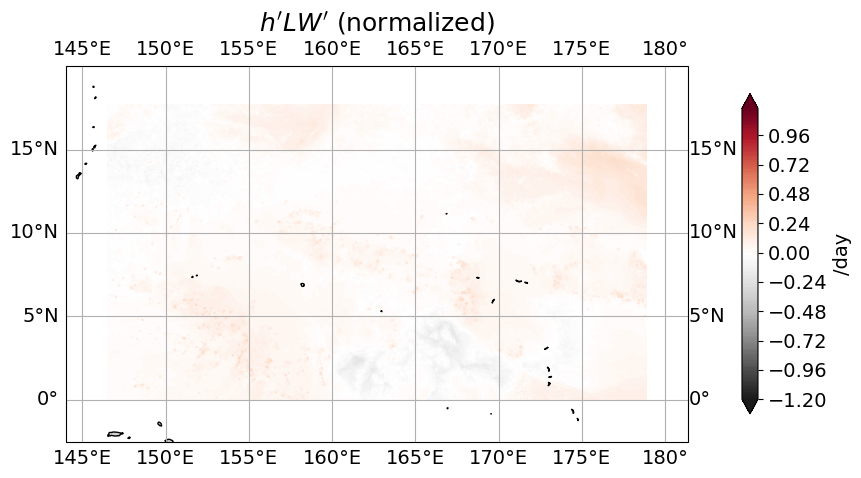

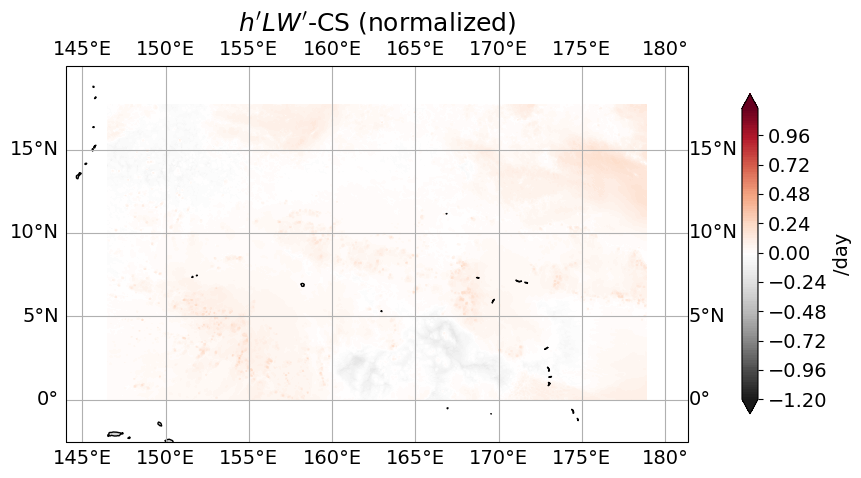

In [ ]:
for ivar in range(2):

    itim = 40

    if ivar == 0:
        pltvar = lwmse[itim,...]
        title = "$h'LW'$ (normalized)"
    elif ivar == 1:
        pltvar = lwmse_cs[itim,...]
        # pltvar = lwmse[itim,...]
        title = "$h'LW'$-CS (normalized)"

    units = '/day'
    clevs = np.arange(-1.,1.,0.02)

    fig = plt.figure(figsize=(12,5))
    proj = cartopy.crs.PlateCarree(central_longitude=offset)
    fig.set_facecolor('white')

    ax = fig.add_subplot(111,projection=proj)
    plt.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='RdGy_r', extend='both', zorder=1)
    cbar=plt.colorbar(shrink=0.85, fraction=0.03, pad=0.05)
    cbar.set_label(units)
    ax.set_title(title, size=18)
    # ax.set_xlabel('[km]')
    # ax.set_ylabel('[km]')
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
                dms=True, x_inline=False, y_inline=False)
    plt.tight_layout()

#### Time series

##### Time series comparing tests

all


/tmp/ipykernel_46164/2678766602.py:50: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/miniconda3/envs/plotting/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_46164/2678766602.py:60: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1, axis=0)


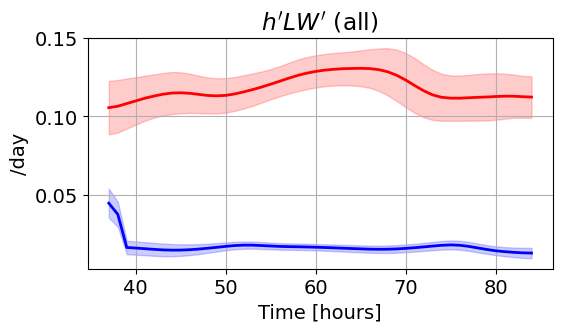

deep


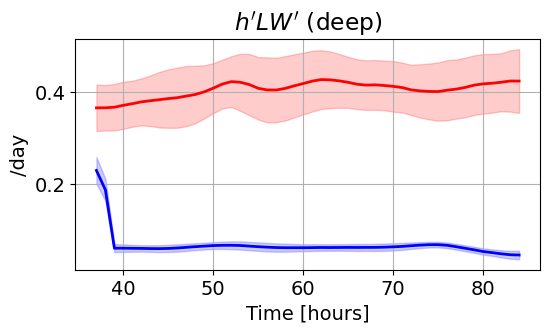

cong


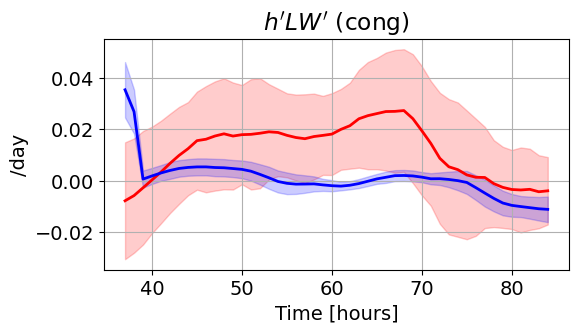

shall


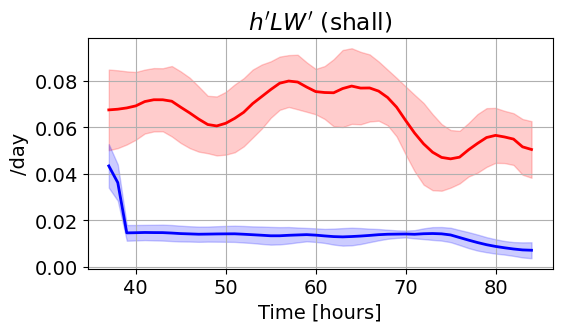

strat


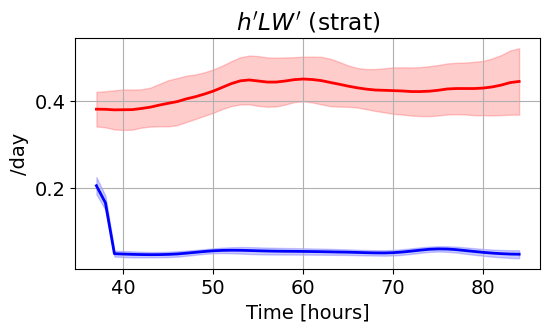

anvil


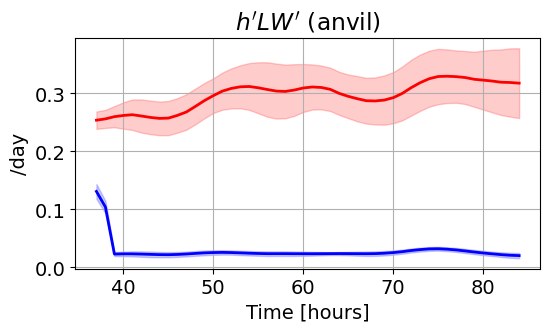

deepcong


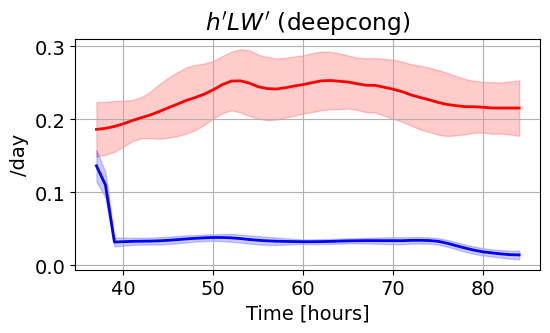

stratanv


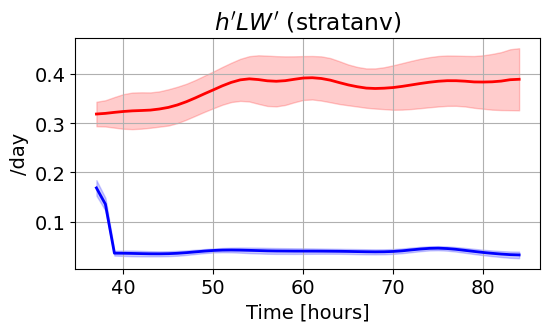

allrain


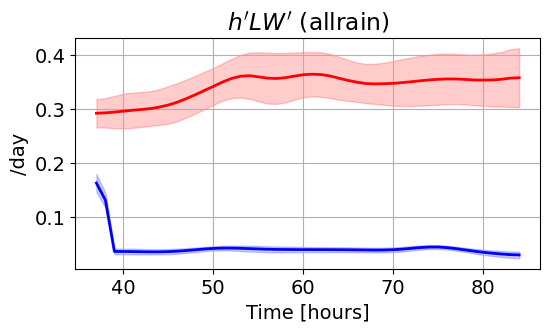

upward


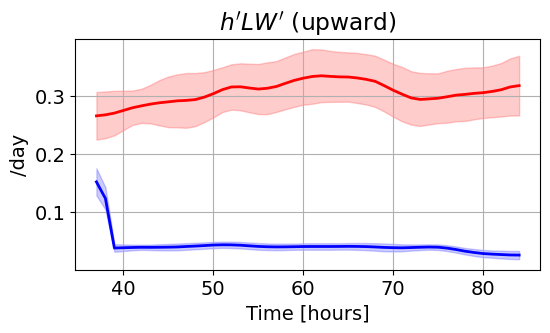

downward


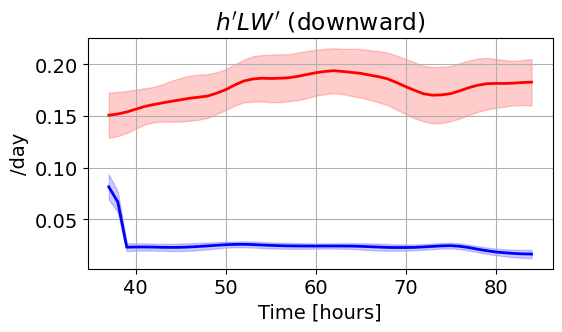

In [ ]:
tshift = get_tshift(tests[itest])
times_ncrf = np.arange(tshift, nt[itest]+tshift, 1)

var0_ivar = lwmse_sav[0, ...]
var1_ivar = lwmse_sav[1, ...]
var0_ivar = var0_ivar[:, :, times_ncrf]
var1_ivar = var1_ivar[:, :, times_ncrf]
figtag = 'lwmse'
ylabel = '/day'
title_tag = "$h'LW'$"

for icond in range(ncond):

    fig_extra=condavg_label[icond]
    condtag=fig_extra #condavg_title[icond]
    print(fig_extra)

    var0 = np.copy(var0_ivar[:, icond, :])
    var1 = np.copy(var1_ivar[:, icond, :])

    # if figtag == 'mse':
    #     title_tag = '$h$'
    # elif figtag == 'vadv_mse':
    #     title_tag = 'VADV($h$) (Eul.)'

#----------------------------------------------------------------

    # Use Pandas to smooth via running mean
    var0 = pd.DataFrame(var0)
    var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
    var1 = pd.DataFrame(var1)
    var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()

    # create figure
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(111)

    ax.set_title(title_tag+' ('+condtag+')')#, fontsize=20)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Time [hours]')

    t_range=[times_ncrf[0], times_ncrf[-1]]
    # plt.xlim(t_range)

    color_t0 = 'red'
    color_t1 = 'blue'

    # Test 0

    mean_t0 = np.nanmean(var0, axis=0)
    std_t0 = np.nanstd(var0, axis=0)

    xdim = times_ncrf

    plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
    plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

    # Test 1

    mean_t1 = np.nanmean(var1, axis=0)
    std_t1 = np.nanstd(var1, axis=0)

    plt.plot(xdim, mean_t1, linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
    plt.fill_between(xdim, mean_t1 + std_t1, mean_t1 - std_t1, alpha=0.2, color=color_t1)

    plt.grid()

    # plt.legend(loc="upper right")

    figdir2 = figdir+'all/'
    figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
    plt.savefig(figname,dpi=200, facecolor='white', \
                bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()

##### Time series showing the normalized change

all


/tmp/ipykernel_46164/3403538343.py:47: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)


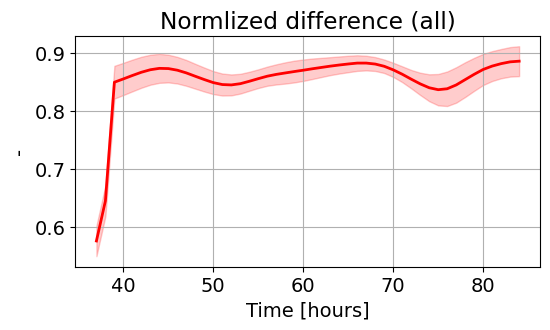

deep


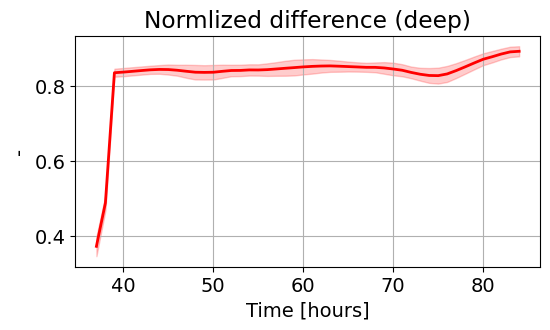

cong


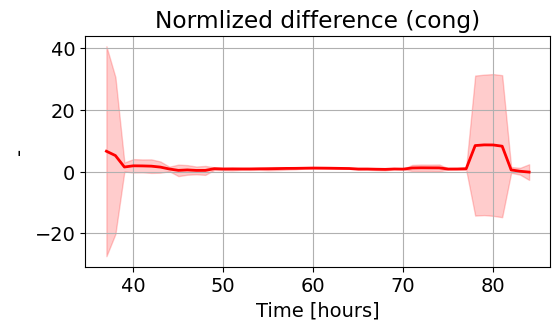

shall


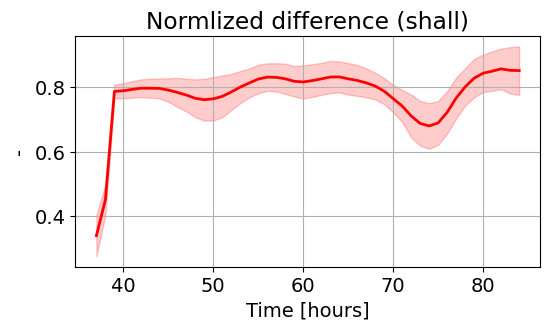

strat


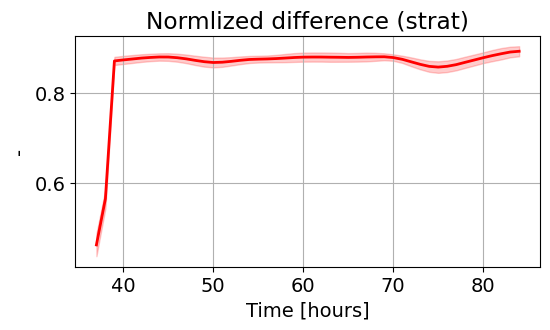

anvil


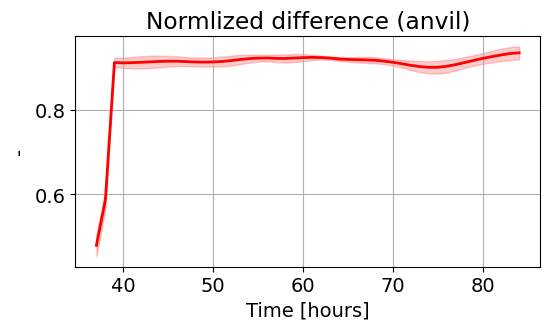

deepcong


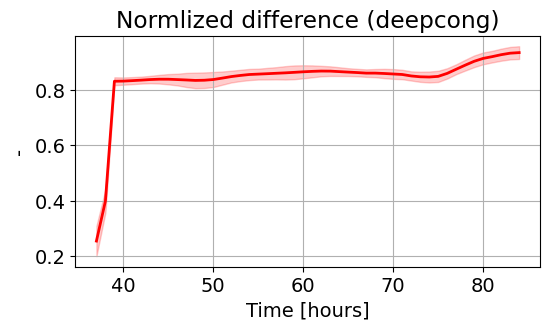

stratanv


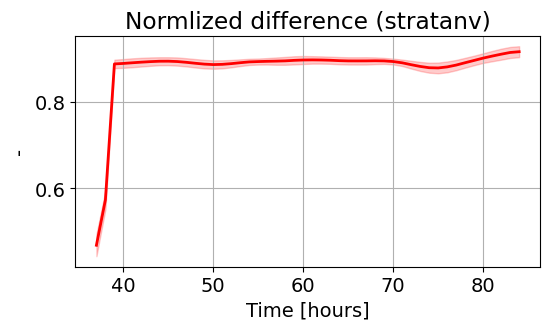

allrain


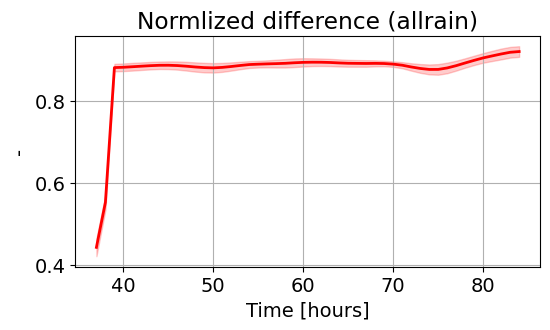

upward


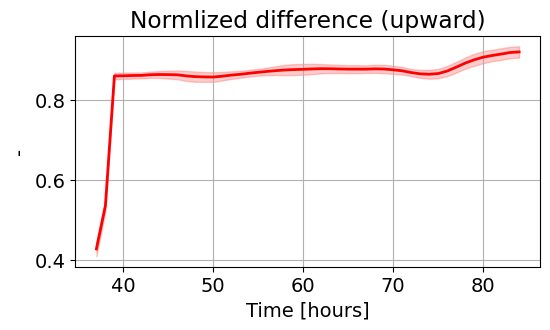

downward


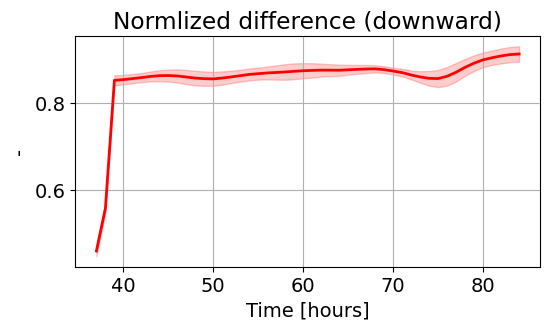

In [ ]:
tshift = get_tshift(tests[itest])
times_ncrf = np.arange(tshift, nt[itest]+tshift, 1)

var0_ivar = lwmse_sav[0, ...]
var1_ivar = lwmse_sav[1, ...]
var0_ivar = var0_ivar[:, :, times_ncrf]
var1_ivar = var1_ivar[:, :, times_ncrf]

var_plot = (var0_ivar - var1_ivar) / var0_ivar

figtag = 'lwmse-dnorm'
ylabel = '-'
title_tag = 'Normlized difference'

for icond in range(ncond):

    fig_extra=condavg_label[icond]
    condtag=fig_extra #condavg_title[icond]
    print(fig_extra)

    var0 = np.copy(var_plot[:, icond, :])

#----------------------------------------------------------------

    # Use Pandas to smooth via running mean
    var0 = pd.DataFrame(var0)
    var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
    var1 = pd.DataFrame(var1)
    var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()

    # create figure
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(111)

    ax.set_title(title_tag+' ('+condtag+')')#, fontsize=20)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Time [hours]')

    t_range=[times_ncrf[0], times_ncrf[-1]]
    # plt.xlim(t_range)

    color_t0 = 'red'
    color_t1 = 'blue'

    # Test 0

    mean_t0 = np.nanmean(var0, axis=0)
    std_t0 = np.nanstd(var0, axis=0)

    xdim = times_ncrf

    plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
    plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

    plt.grid()

    # plt.legend(loc="upper right")

    figdir2 = figdir+'all/'
    figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
    plt.savefig(figname,dpi=200, facecolor='white', \
                bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()